In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from cv2 import cv2

## Green function of interacting waves with multiple stimulation points

$$G(x, t) = \sum_i \Theta (\Delta t_\text{arr} - \tau_r) \Theta (t_i - \frac{\rho_i}{v}) e^{-\frac{(t_i-\rho_i/v)}{\tau}} e^{-\frac{\rho_i}{\rho_c}}$$

$$\Delta t_\text{arr} = (t_i + \frac{\rho_i}{v}) - (t_\text{last} + \frac{\rho_{\text{last}}}{v})$$

In [4]:
def greens_function_multiple(x, y, t, stimpoints, form='fast', refractory=0):
    
    if form == 'fast':
        tau = 1
        rho_e = 60
        v = 500
        c_x = 1
        c_y = 1
    elif form == 'slow':
        tau = 5
        rho_e = 8
        v = 1
        c_x = 20
        c_y = 1
    
    res = 0
    
    def rho_func(x0, y0):
        return np.sqrt(c_x * (x - x0) ** 2 + c_y * (y - y0) ** 2)
    
    def arr_time(x0, y0, t0):
        return t0 + rho_func(x0, y0) / v
    
    # Remove those non-effect stimpoints
    stimpoints = sorted(stimpoints, key = lambda p : arr_time(p[0], p[1], p[2]))
    
    stop = False
    while not stop:
        lenall = len(stimpoints)
        for i in range(1, lenall):
            curr = stimpoints[i]
            prev = stimpoints[i-1]
            if arr_time(curr[0], curr[1], curr[2]) - arr_time(prev[0], prev[1], prev[2]) < refractory:
                stimpoints.remove(curr)
        if lenall == len(stimpoints):
            stop = True
    
    for x0, y0, t0 in stimpoints:       
        t = t - t0
        rho = rho_func(x0, y0)
        res += np.heaviside(t - rho / v, 1) * np.exp(-(t - rho / v) / tau) * np.exp(-rho / rho_e)
        
    
    return res

In [5]:
numx = 30
numy = 60
stims = [(numx // 2, numy // 2 - 10, 0),
         (numx // 2, numy // 2 + 10, 0)]

### Fast

In [6]:
dt = 0.001
dx = 1
dy = 1

trange = np.arange(0, 0.2, dt)
xrange = np.arange(0, numx, dx)
yrange = np.arange(0, numy, dy)

data_mat = np.zeros((len(trange), len(xrange), len(yrange)))
for k, t in tqdm(enumerate(trange)):
    for i, x in enumerate(xrange):
        for j, y in enumerate(yrange):
            data_mat[k, i, j] = greens_function_multiple(x, y, t, stims, 'fast', 0.1)

200it [00:15, 12.94it/s]


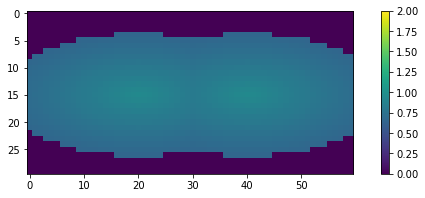

In [134]:
plt.figure(figsize=(10,3))
plt.imshow(data_mat[50], vmin=0, vmax=2)
plt.colorbar()
plt.show()

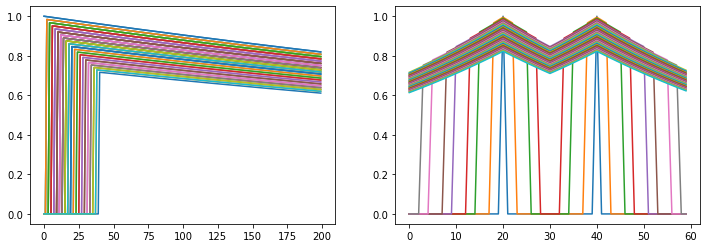

In [7]:
data_lon = data_mat[:, 15]
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
ax1.plot(data_lon)
ax2 = fig.add_subplot(122)
ax2.plot(data_lon[::5].T)
plt.show()

### Slow

In [12]:
dt = 0.1
dx = 1
dy = 1

trange = np.arange(0, 50, dt)
xrange = np.arange(0, numx, dx)
yrange = np.arange(0, numy, dy)

data_mat = np.zeros((len(trange), len(xrange), len(yrange)))
for k, t in tqdm(enumerate(trange)):
    for i, x in enumerate(xrange):
        for j, y in enumerate(yrange):
            data_mat[k, i, j] = greens_function_multiple(x, y, t, stims, 'slow', 50)

500it [00:44, 11.28it/s]


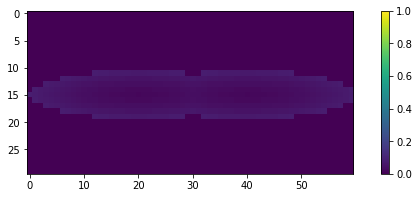

In [13]:
plt.figure(figsize=(10,3))
plt.imshow(data_mat[200], vmin=0, vmax=1)
plt.colorbar()
plt.show()

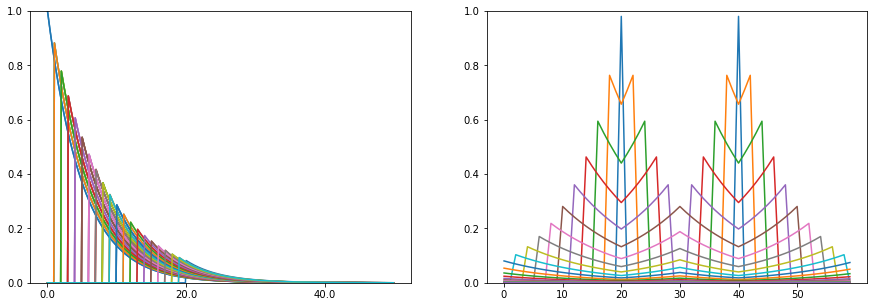

In [14]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1.plot(data_mat[:, data_mat.shape[1] // 2, ::])
ax1.set_ylim(0, 1)
ax1.set_xticks(range(0, len(trange), 200))
ax1.set_xticklabels(trange[::200])

ax2 = fig.add_subplot(122)
ax2.plot(data_mat[1::20, data_mat.shape[1] // 2, ::1].T)
ax2.set_ylim(0, 1)
ax2.set_xticks(range(0, len(yrange), 10))
ax2.set_xticklabels([int(y) for y in yrange[::10]])
plt.show()

In [15]:
# Save video

numx = 30
numy = 60
dt = 0.1
dpi = 100

fig = plt.figure()
        
for iframe in range(len(data_mat)):

    plt.clf()
    plt.imshow(np.flip(data_mat[iframe].T, 0),
               vmin=0,
               vmax=1,
               cmap='hot')
    plt.text(1, 5, str(iframe * dt) + 's', color='white', size=15, fontweight='bold')
    plt.colorbar()
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

    plt.savefig('../../results/video/frames/img' + str(iframe) + '.jpg', dpi=dpi, bbox_inches='tight')
    plt.close()

In [16]:
# Make video
fps = 50
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
ny, nx, _ = cv2.imread('../../results/video/frames/img0.jpg').shape
videoWriter = cv2.VideoWriter('../../results/video/greens_function/slow_interact.avi', fourcc, fps, (nx, ny))

for iframe in range(len(data_mat)):
    frame = cv2.imread('../../results/video/frames/img' + str(iframe) + '.jpg')
    videoWriter.write(frame)
videoWriter.release()
cv2.destroyAllWindows()